In [1877]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [1878]:
from sklearn.cluster import KMeans

In [1879]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split,  GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

In [1880]:
from sklearn.linear_model import LogisticRegression

In [1881]:
from catboost import CatBoostClassifier

# Сервисные процедуры и функции

In [1882]:
path = '/datasets/final_provider/'

#path = r'C:\\_GoogleDrive\\...'

In [1883]:
# Функция отоброжения ROC кривой  
#
def plot_roc_curve_test(clf, X, y):
    '''
    Для обученной модели строим roc_curve на тестовых данных
    '''
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    
    y_pred_proba = clf.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y,  y_pred_proba)
    ax.plot(fpr, tpr, color='b', label='ROC (AUC = %0.3f)' % (auc(fpr, tpr)), lw=2, alpha=.8)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],title="Характеристика ROC")
    ax.legend(loc="lower right")
    ax.set_xlabel('FP Rate')
    ax.set_ylabel('TP Rate')
    
    plt.show()

In [1884]:
def plot_result(cv_results_):
    '''
    Выводим результаты оптимизации
    '''
    plt.figure(figsize=(15,5))
    df_tmp= pd.DataFrame(cv_results_)
    columns = ['mean_test_roc_auc', 'mean_test_accuracy']
    for i, column in enumerate(columns):
        ax = plt.subplot(1,2, i+1)
        ax.scatter(data = df_tmp, x=df_tmp.index, y = column);
        ax.set_title('Изменение '+column+' при подборе параметров')
        ax.set_xlabel('Итерация')
        ax.set_ylabel('Метрика')

In [1885]:
def plot_target_by_feature(df_inp, feature, group = 'exited'):
    '''
    Функция отображает круговую диаграмму - структуру признака -  по каждому значению фичи 
    '''
    plt.figure(figsize = (16,10))
    for i, (el, data) in enumerate(df_inp.groupby(feature)):
        df = data[group].value_counts(normalize = True).mul(100).round(1).astype(str)
        ax = plt.subplot(2,4, i+1)
        ax.pie(df, labels = [group+': '+ str(x) for x in df.index ], autopct='%1.1f%%' );
        
        ax.set_title(feature+': '+str(el)+'\n'+str(data.shape[0])+', '+str(np.round(100*data.shape[0]/df_full.shape[0],1))+'%')
    

# 1. Загрузка данных и первичный анализ данных.

BeginDate – дата начала пользования услугами,

EndDate – дата окончания пользования услугами,

Type – тип оплаты: ежемесячный, годовой и тд,

PaperlessBilling – безналичный расчет,

PaymentMethod – способ оплаты,

MonthlyCharges – ежемесячные траты на услуги,

TotalCharges – всего потрачено денег на услуги

Dependents – наличие иждивенцев

Senior Citizen – наличие пенсионного статуса по возрасту

Partner – наличие супруга(и)

MultipleLines – наличие возможности ведения параллельных линий во время звонка

## 1.1. personal.csv

In [1886]:
df_pers = pd.read_csv(path+'personal.csv')

In [1887]:
df_pers.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


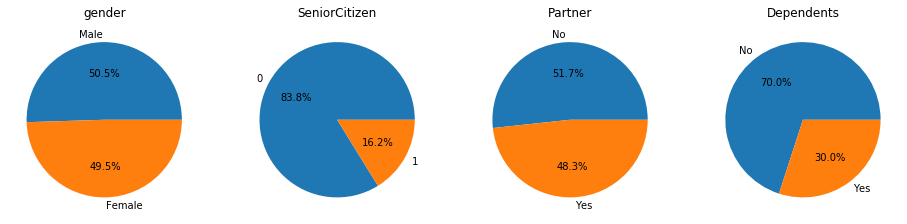

In [1888]:
# Посмотрим структуру категориальных полей

plt.figure(figsize = (16,10))

for i, column in enumerate(column for column in df_pers.columns if column != 'customerID'):
    ax = plt.subplot(2,4, i+1)
    df = df_pers[column].value_counts(normalize = True).mul(100).round(1).astype(str)
    ax.pie(df, labels = df.index, autopct='%1.1f%%' )
    ax.set_title(column)
    #print()
    

In [1889]:
columns_to_map = ['Partner', 'Dependents']
for column in columns_to_map:
    df_pers[column] = df_pers[column].map({'Yes':1, 'No':0}).astype('int')

In [1890]:
df_pers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null int64
Dependents       7043 non-null int64
dtypes: int64(3), object(2)
memory usage: 275.2+ KB


Пропусков данных нет,преобразование типов не требуется. В структуре полей каких то странностей тоже не замечено.

## 1.2. contract.csv

In [1891]:
df_cont = pd.read_csv(path+'contract.csv')

In [1892]:
df_cont.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


**Для начала ответим на важнейший вопрос, одна строка в файле это один пользователь? или он повторяется и есть какая то динамика пользователя по периодам?**

In [1893]:
df_cont['customerID'].nunique()

7043

Итак, мы имеем данные одна строка один уникальный пользователь, значит временного ряда нет, значит работаем просто как со срезом данных.

Первые шаги это привести типы в соответствие. Даты в даты, числа в числа. Убрать пропуски.

In [1894]:
# Заполним пустые значения нулями

df_cont.loc[df_cont.TotalCharges == ' ','TotalCharges'] = 0

In [1895]:
# Сконвертируем типы колонок

df_cont['BeginDate'] =  pd.to_datetime(df_cont['BeginDate'], format='%Y-%m-%d')
df_cont['MonthlyCharges'] = pd.to_numeric(df_cont['MonthlyCharges'] , errors='coerce')
df_cont['TotalCharges'] = pd.to_numeric(df_cont['TotalCharges'] , errors='coerce')

In [1896]:
 df_cont['PaperlessBilling'] = df_cont['PaperlessBilling'].map({'Yes':1, 'No':0}).astype('int')

In [1897]:
#Создадим колонку, целевой признак. Если EndDate == 'No' клиент не ушел, иначе клиент ушел и мы знаем дату ухода.

df_cont['exited'] = df_cont['EndDate'].apply(lambda x: 0 if x =='No' else 1 )


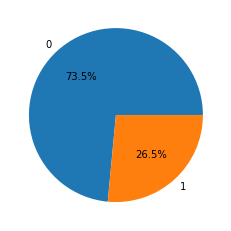

In [1898]:
# Визуализизируем структуру целевого признака

df = df_cont['exited'].value_counts(normalize = True).mul(100).round(1).astype(str)
plt.pie(df, labels = df.index, autopct='%1.1f%%' );

Налицо дисбаланс, скорее всего придется корректировать.

In [1899]:
# Так как в дальнейшем скорее всего потребуется считать как долго клиент пользуется сервисом, заполним пустые значения
# в дате рассторжения - датой выгрузки  '2020-02-01'

df_cont.loc[df_cont['EndDate'] =='No', 'EndDate'] = '2020-02-01'
df_cont['EndDate'] =  pd.to_datetime(df_cont['EndDate'], format='%Y-%m-%d')

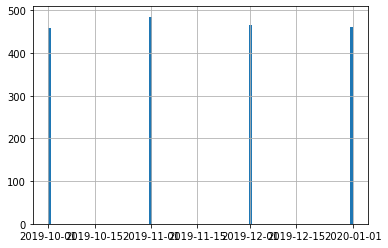

In [1900]:
# Странная ситуация с датами рассторжения. Всего 4 уникальных значения

df_cont[df_cont['EndDate'] != '2020-02-01']['EndDate'].hist(bins = 100);

In [1901]:
df_cont['EndDate'].value_counts()

2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: EndDate, dtype: int64

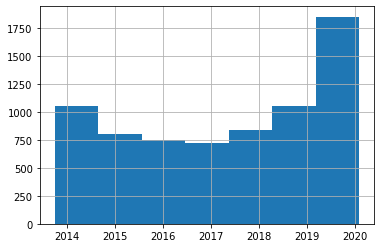

In [1902]:
# Хотя даты подключения к услугам есть за 7 лет

df_cont['BeginDate'].hist(bins = 7);

Странная ситуация с датой рассторжения, всего 4 уникальных значения в 2019 году, тогда как дата заключения есть аж за 7 лет.

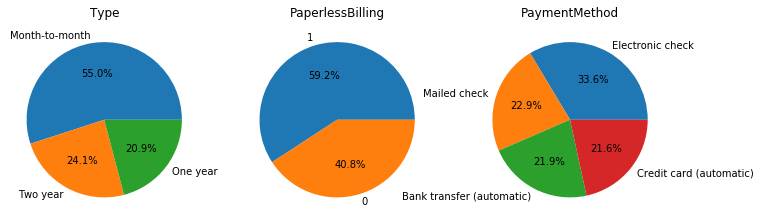

In [1903]:
# Посмотрим структуру категориальных полей

plt.figure(figsize = (16,10))

columns =['Type','PaperlessBilling','PaymentMethod']
for i, column in enumerate(columns):
    ax = plt.subplot(2,4, i+1)
    df = df_cont[column].value_counts(normalize = True).mul(100).round(1).astype(str)
    ax.pie(df, labels = df.index, autopct='%1.1f%%' )
    ax.set_title(column)
    #print()
    

In [1904]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
exited              7043 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 495.3+ KB


Начальная предобработка данных выполнена,  структура полей и структура данных изучена.

## 1.3. internet.csv

In [1905]:
df_int = pd.read_csv(path+'internet.csv')

In [1906]:
df_int.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [1907]:
df_int.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

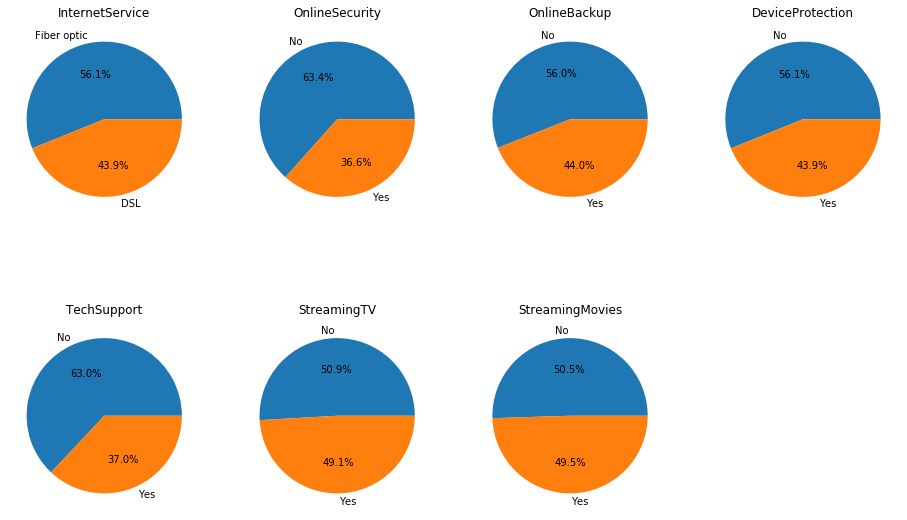

In [1908]:
# Посмотрим структуру категориальных полей

plt.figure(figsize = (16,10))

columns =['InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for i, column in enumerate(columns):
    ax = plt.subplot(2,4, i+1)
    df = df_int[column].value_counts(normalize = True).mul(100).round(1).astype(str)
    ax.pie(df, labels = df.index, autopct='%1.1f%%' )
    ax.set_title(column)
    #print()
    

In [1909]:
columns_to_map = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for column in columns_to_map:
    df_int[column] = df_int[column].map({'Yes':1, 'No':0}).astype('int')
    
# Создадим новую колонку количество интернет сервисов    
df_int['int_serv_count'] =df_int[columns_to_map].sum(axis = 1)

# Создадим новую колонку для пользователей интернет сервисов код 2
df_int['int_user'] = 2

In [1910]:
df_int.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,int_serv_count,int_user
0,7590-VHVEG,DSL,0,1,0,0,0,0,1,2
1,5575-GNVDE,DSL,1,0,1,0,0,0,2,2
2,3668-QPYBK,DSL,1,1,0,0,0,0,2,2
3,7795-CFOCW,DSL,1,0,1,1,0,0,3,2
4,9237-HQITU,Fiber optic,0,0,0,0,0,0,0,2


In [1911]:
df_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 10 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null int64
OnlineBackup        5517 non-null int64
DeviceProtection    5517 non-null int64
TechSupport         5517 non-null int64
StreamingTV         5517 non-null int64
StreamingMovies     5517 non-null int64
int_serv_count      5517 non-null int64
int_user            5517 non-null int64
dtypes: int64(8), object(2)
memory usage: 431.1+ KB


Пользователей интернет меньше обчего числа пользователей. 

## 1.4. phone.csv

In [1912]:
df_phone = pd.read_csv(path+'phone.csv')

In [1913]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


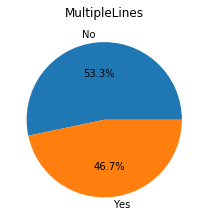

In [1914]:
# Посмотрим структуру категориальных полей

plt.figure(figsize = (16,10))

columns =['MultipleLines']
for i, column in enumerate(columns):
    ax = plt.subplot(2,4, i+1)
    df = df_phone[column].value_counts(normalize = True).mul(100).round(1).astype(str)
    ax.pie(df, labels = df.index, autopct='%1.1f%%' )
    ax.set_title(column)
    #print()
    

In [1915]:
df_phone['MultipleLines'] = df_phone['MultipleLines'].map({'Yes':1, 'No':0}).astype('int')

# Создадим новую колонку для пользователей телефонии код 1
df_phone['phone_user'] = 1

In [1916]:
df_phone.head()

,customerID,MultipleLines,phone_user
0,5575-GNVDE,0,1
1,3668-QPYBK,0,1
2,9237-HQITU,0,1
3,9305-CDSKC,1,1
4,1452-KIOVK,1,1


In [1917]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null int64
phone_user       6361 non-null int64
dtypes: int64(2), object(1)
memory usage: 149.2+ KB


Пользователей телефонной связи меньше обчего числа пользователей. 

# 2. План работ по проекту.

Шаг 1.  Объединение данных в одну таблицу. Персоны и контракты количество совпадает, пользователи интернет и телефонной связи количество строк меньше, пропуски скорее всего заполним None и это значение будет как новая категория. Далее пользователей только интернет, только телефонии и того и другого тоже категоризирую, возможно буду делать разные модели, либо это будт просто новый признак.

Шаг 2. Новые фичи. Пока видится только срок пользования например в месяцах. Возможно еще год заключения договора.

Шаг 3. Кодование категориальных признаков. Пока по ощущениям буду использова OHE кодирование, количество полей не очень большое и количество значений тоже. Для регрессионной модели подойдет, для деревянных моделей возможно применю боле хитрое кодирование типа закодирую числовой вероятностью этой категории по целевому признаку.

Шаг 4. Дисбаланс классов. Скорее всего придется слегка докинуть целевого класса например методом UpSampling. Возможно балансировку сделаю средтвами модели балансировкой весов. 

Шаг 5. Выполню нормализацию. Разобью  на тестовую и тренировочные выборки. Т.к. это не временной ряд, то с перемешиванием и соблюдением баланса классов.

Шаг 6. Выбор модели. Пока по ощущениям буду использовать Регрессию c регуляризацией и каойто бустинг над деревьями типа LGBM и CatBoost. Дальше что лучше подойдет.

Шаг 7. Метрики. ROC_AUC, accuracy

Шаг 8. Тюннинг моделей. сначала RandomizedSearchCV затем возле лучших значений более точный поиск GridSearchCV

# 3. Подготовка данных для моеделей.

In [1918]:
cores = -1
state = 12345

## 3.1. Объединение данных и фиче инжениринг

In [2022]:
df_full = df_pers.merge(df_cont, on = 'customerID')

In [2023]:
# df_full.head()

In [2024]:
# df_full.info()

Персоны и контракты слились. 12 полей 7043 записей, пустых полей пока нет.

In [2025]:
df_full = df_full.merge(df_int, on = 'customerID', how = 'left') 

In [2026]:
# df_full.info()

In [2027]:
df_full = df_full.merge(df_phone, on = 'customerID', how = 'left')

In [2028]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null int64
Dependents          7043 non-null int64
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
exited              7043 non-null int64
InternetService     5517 non-null object
OnlineSecurity      5517 non-null float64
OnlineBackup        5517 non-null float64
DeviceProtection    5517 non-null float64
TechSupport         5517 non-null float64
StreamingTV         5517 non-null float64
StreamingMovies     5517 non-null float64
int_serv_count      5517 non-null float64
int_user    

In [2029]:
# Оценим пропуски после объединения
df_full.loc[df_full.isnull().any(axis= 1), df_full.isnull().any()]

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,int_serv_count,int_user,MultipleLines,phone_user
0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN
3,DSL,1.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,NaN,NaN
7,DSL,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
7029,DSL,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,NaN,NaN
7030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
7036,DSL,0.0,1.0,1.0,1.0,1.0,1.0,5.0,2.0,NaN,NaN
7037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0


In [2030]:
# Пустые значения в InternetService заменим на 'None'
df_full['InternetService'].fillna('None', inplace = True )

# В остальных полях заполним нулями
df_full.fillna(0, inplace = True )

In [2031]:
# Создадим новую колонку - тип пользователя 1 - телефон, 2 - Интернет, 3 - и то и другое
df_full['user_type'] = df_full['int_user'] +  df_full['phone_user']

In [2032]:
# Создадим две колонки на основе дат. 

# Количество месяцев пользования для фичи описывающей длительность пользования
df_full['weeks'] = (df_full.EndDate - df_full.BeginDate)//np.timedelta64(1, 'W')

# Год заключения контракта, для учета особенность возможных условий заключения договора.
df_full['begin_year'] = df_full.BeginDate.dt.year.astype('int64')
df_full['is_old'] = df_full['begin_year'].apply(lambda  x: 1 if x < 2018 else 0)

In [2033]:
# Примедем булевы поля к малому целому типу
columns = ['SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','int_serv_count','int_user','MultipleLines', 'user_type', 'phone_user', 'exited']
for column in columns:
    df_full[column] = df_full[column].astype('int') 

In [2034]:
df_full.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,StreamingTV,StreamingMovies,int_serv_count,int_user,MultipleLines,phone_user,user_type,weeks,begin_year,is_old
0,7590-VHVEG,Female,0,1,0,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,...,0,0,1,2,0,0,2,4,2020,0
1,5575-GNVDE,Male,0,0,0,2017-04-01,2020-02-01,One year,0,Mailed check,...,0,0,2,2,0,1,3,148,2017,1
2,3668-QPYBK,Male,0,0,0,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,...,0,0,2,2,0,1,3,8,2019,0
3,7795-CFOCW,Male,0,0,0,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),...,0,0,3,2,0,0,2,195,2016,1
4,9237-HQITU,Female,0,0,0,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,...,0,0,0,2,0,1,3,8,2019,0


In [2035]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 28 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null int64
Dependents          7043 non-null int64
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
exited              7043 non-null int64
InternetService     7043 non-null object
OnlineSecurity      7043 non-null int64
OnlineBackup        7043 non-null int64
DeviceProtection    7043 non-null int64
TechSupport         7043 non-null int64
StreamingTV         7043 non-null int64
StreamingMovies     7043 non-null int64
int_serv_count      7043 non-null int64
int_user            7043 n

Пропусков нет, колонки с нужными типами

In [2036]:
# Удалим лишние колонки

# Даты и ИД Пользователя
#

df_full = df_full.drop(['EndDate', 'BeginDate', 'customerID', 'begin_year'], axis = 1)

# Общие начисления дают повышенную кореляцию с количеством месяцев и средними начислениями в месяц
df_full = df_full.drop(['TotalCharges'], axis = 1)

# Булевы колонки по сервисам, учтены в новой колонке количество интернет сервисов int_serv_count
df_full = df_full.drop(['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', \
                        'TechSupport','StreamingTV','StreamingMovies', 'int_user',  'phone_user'], axis = 1)


In [2037]:
df_full.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,exited,InternetService,int_serv_count,MultipleLines,user_type,weeks,is_old
0,Female,0,1,0,Month-to-month,1,Electronic check,29.85,0,DSL,1,0,2,4,0
1,Male,0,0,0,One year,0,Mailed check,56.95,0,DSL,2,0,3,148,1
2,Male,0,0,0,Month-to-month,1,Mailed check,53.85,1,DSL,2,0,3,8,0
3,Male,0,0,0,One year,0,Bank transfer (automatic),42.30,0,DSL,3,0,2,195,1
4,Female,0,0,0,Month-to-month,1,Electronic check,70.70,1,Fiber optic,0,0,3,8,0


In [2038]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 15 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null int64
Dependents          7043 non-null int64
Type                7043 non-null object
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
exited              7043 non-null int64
InternetService     7043 non-null object
int_serv_count      7043 non-null int64
MultipleLines       7043 non-null int64
user_type           7043 non-null int64
weeks               7043 non-null int64
is_old              7043 non-null int64
dtypes: float64(1), int64(10), object(4)
memory usage: 880.4+ KB


Готово базовый фиче инжениринг выполнен:

- созданы дополнительные колонки **int_serv_count, user_type, number_of_months, begin_year**
- удалены колонки  **EndDate, BeginDate, customerID, TotalCharges, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport,StreamingTV,StreamingMovies**

## 3.2. Анализ таргета по категориальным признакам

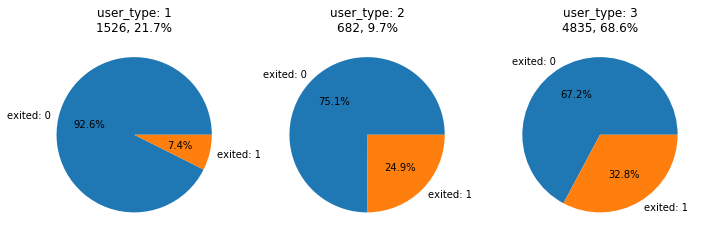

In [2039]:
plot_target_by_feature(df_full, 'user_type')

Анализ по условным типав пользователей показывает, что наиболее стабильны пользователи только телефонной связи

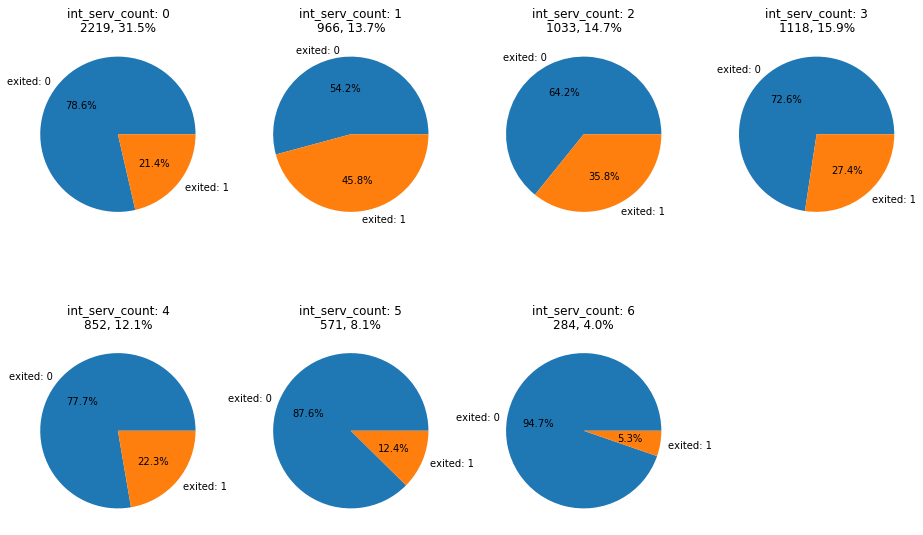

In [2040]:
plot_target_by_feature(df_full,'int_serv_count')

Интересная картина по таргету с ростом количества сервисов. Особо не стабильны пользователи одного сервиса, с ростом числа стабильность пользователя растет. Логично.

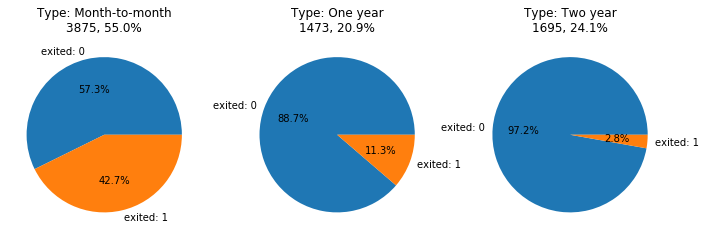

In [2041]:
plot_target_by_feature(df_full, 'Type')

Также логичная картина по длине контракта, те кто заключил длинные контракты уходить не хочет. Наиболее нестабильны те кто платить ежемесячно. И доля таких очень высока, более 50% пользователей.Однозначно зона для улучшений

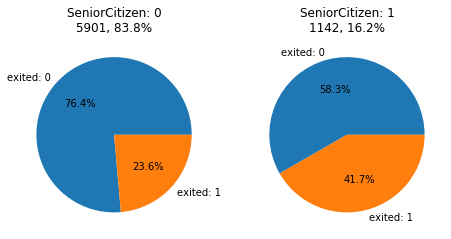

In [2042]:
plot_target_by_feature(df_full, 'SeniorCitizen')

Небольшая группа пенсионеров склонна к уходу.

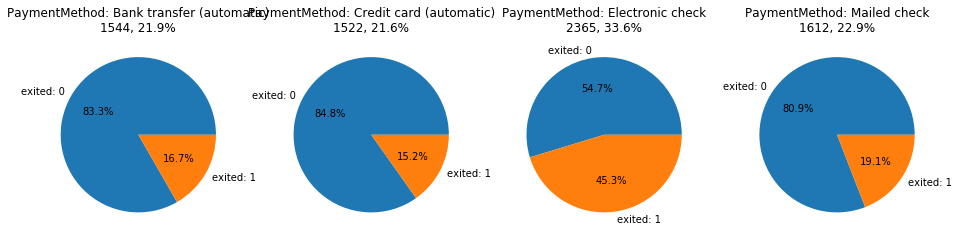

In [2043]:
plot_target_by_feature(df_full, 'PaymentMethod')

Интересный неожиданных сегмент это пользователи с Electronic check, склонны к уходу, и доля их весьма велика 33 %

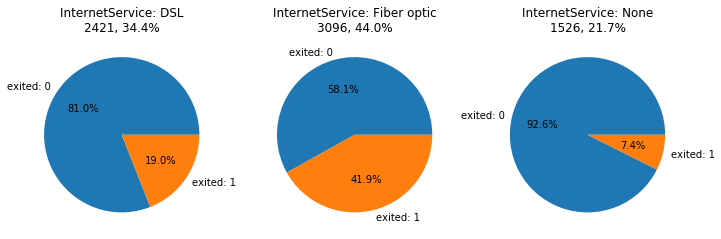

In [2044]:
plot_target_by_feature(df_full, 'InternetService')

Неожиданный сегмент те кто на оптике склонны уйти, видимо связано с величной оплаты и постоянным поиском более выгодного варианта, хотя оптика должна бы наоборот привязывать.

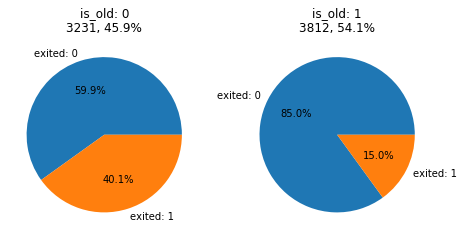

In [2045]:
 plot_target_by_feature(df_full, 'is_old')

begin_year (поле удалено)

Также вполне логичный вывод, пользователи с ранним сроком подключения более стабильны, видимо особенность выгрузки, пользователи уже ушли и в выгрузку не попали. Не зря было создано поле.


is_old

Сейчас сделано поле "условно старый клиент", логика таже старые более стабильны, новые менее.

Общий вывод по анализу целевого признака - **Очень мультисегментирован**, напрашивается какой то этап кластериазции, и возможно раздельное моделирование по каждому кластеру. Сейчас приведем колонки к числовому типу и кластеризацию выполним.

(справочно, раздельное моделирование по типу пользователя проведено ('user_type'), если отдельно предсказыать уход для наибольшей группы Код 3 (и интернет и телефон) результаты оказались хуже, чем по всей выборке)

## 3.2. Обработаем категориальные переменные.

За основу возмем One Hot Encoding. Оставшихся колонок не так много, значений в них также.

In [2046]:
# Исходный датасет пригодится для КатБуста, поэтому сделаем копию.

df_OHE = df_full.copy()

In [2047]:
df_OHE.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,exited,InternetService,int_serv_count,MultipleLines,user_type,weeks,is_old
0,Female,0,1,0,Month-to-month,1,Electronic check,29.85,0,DSL,1,0,2,4,0
1,Male,0,0,0,One year,0,Mailed check,56.95,0,DSL,2,0,3,148,1
2,Male,0,0,0,Month-to-month,1,Mailed check,53.85,1,DSL,2,0,3,8,0
3,Male,0,0,0,One year,0,Bank transfer (automatic),42.30,0,DSL,3,0,2,195,1
4,Female,0,0,0,Month-to-month,1,Electronic check,70.70,1,Fiber optic,0,0,3,8,0


In [2048]:
# Колонки для OHE кодирования
categorial = ['gender', 'Type', 'PaymentMethod', 'InternetService', 'user_type' , 'int_serv_count']

# Для исключения мультиколинеарности первую колонку удаляем
df_OHE = pd.get_dummies(df_OHE, columns = categorial, drop_first = True)

In [2049]:
df_OHE.head()

,SeniorCitizen,Partner,Dependents,PaperlessBilling,MonthlyCharges,exited,MultipleLines,weeks,is_old,gender_Male,...,InternetService_Fiber optic,InternetService_None,user_type_2,user_type_3,int_serv_count_1,int_serv_count_2,int_serv_count_3,int_serv_count_4,int_serv_count_5,int_serv_count_6
0,0,1,0,1,29.85,0,0,4,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0,0,0,0,56.95,0,0,148,1,1,...,0,0,0,1,0,1,0,0,0,0
2,0,0,0,1,53.85,1,0,8,0,1,...,0,0,0,1,0,1,0,0,0,0
3,0,0,0,0,42.30,0,0,195,1,1,...,0,0,1,0,0,0,1,0,0,0
4,0,0,0,1,70.70,1,0,8,0,0,...,1,0,0,1,0,0,0,0,0,0


In [2050]:
df_OHE['exited'] = df_OHE.pop('exited')

In [2051]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
SeniorCitizen                            7043 non-null int64
Partner                                  7043 non-null int64
Dependents                               7043 non-null int64
PaperlessBilling                         7043 non-null int64
MonthlyCharges                           7043 non-null float64
MultipleLines                            7043 non-null int64
weeks                                    7043 non-null int64
is_old                                   7043 non-null int64
gender_Male                              7043 non-null uint8
Type_One year                            7043 non-null uint8
Type_Two year                            7043 non-null uint8
PaymentMethod_Credit card (automatic)    7043 non-null uint8
PaymentMethod_Electronic check           7043 non-null uint8
PaymentMethod_Mailed check               7043 non-null uint8
InternetService_Fiber optic          

## 3.3. Оценка кластеров в данных

Подготовим центры кластеров на основе таргета, на случай если все таким решим делать кластеризацию до 2 кластеров, изначально видится логичным. 

In [2052]:
# Таргет = 0. Центр кластера - средние значения.

center_0 = list(df_OHE[df_OHE.exited == 0].mean())
np.array(center_0)

array([1.28720526e-01, 5.28218013e-01, 3.44800928e-01, 5.35562428e-01,
       6.12651237e+01, 4.09934287e-01, 1.63092192e+02, 6.26014689e-01,
       5.07344414e-01, 2.52609200e-01, 3.18322381e-01, 2.49323541e-01,
       2.50096637e-01, 2.52029378e-01, 3.47700039e-01, 2.73096250e-01,
       9.89563201e-02, 6.27947429e-01, 1.01275609e-01, 1.28140704e-01,
       1.56938539e-01, 1.27947429e-01, 9.66370313e-02, 5.19907228e-02,
       0.00000000e+00])

In [2053]:
# Таргет = 1. Центр кластера - средние значения.

center_1 = list(df_OHE[df_OHE.exited == 1].mean())
np.array(center_1)

array([2.54681648e-01, 3.57945425e-01, 1.74424826e-01, 7.49063670e-01,
       7.44413323e+01, 4.54788657e-01, 7.77704655e+01, 3.06581059e-01,
       4.97592295e-01, 8.88175495e-02, 2.56821830e-02, 1.24130551e-01,
       5.73033708e-01, 1.64794007e-01, 6.93953986e-01, 6.04601391e-02,
       9.09577314e-02, 8.48582129e-01, 2.36490102e-01, 1.97966827e-01,
       1.63723917e-01, 1.01658641e-01, 3.79882290e-02, 8.02568218e-03,
       1.00000000e+00])

Оценим оптимальное число кластеров.

In [2054]:
distortion = []
K = range(1, 10)
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(df_OHE)
    distortion.append(model.inertia_) 

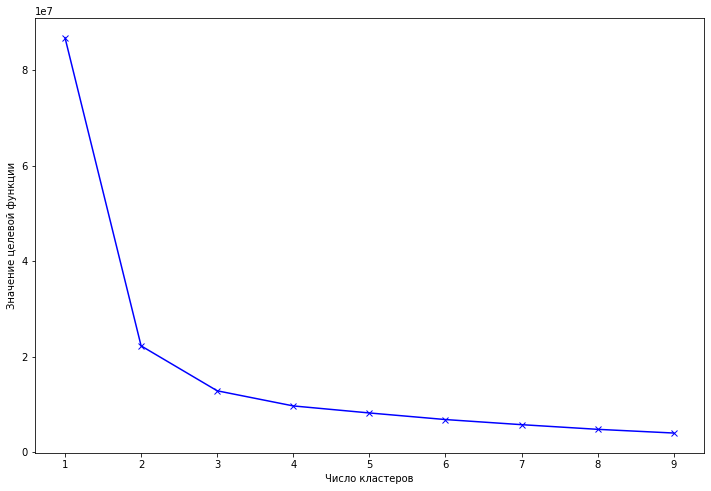

In [2055]:
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show() 

Всетаки это далеко не 2 кластера. Исходя из графика видится логичным 3 кластера, однако в нашем случае кластеризация используется как метод который в сочетаниях группы полей может увидеть новые знания, поэтому будет использовано 5 кластеров. 

In [2056]:
# Выполним кластеризацию, центры не пригодились.

model = KMeans(n_clusters=5, random_state=state)
model.fit(df_OHE)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=12345, tol=0.0001, verbose=0)

In [2057]:
# Добавим метки кластеров в кодированный и исходный датасеты

df_OHE['cluster'] = model.labels_
df_full['cluster'] = model.labels_

In [2058]:
df_OHE['exited'] = df_OHE.pop('exited')

In [2059]:
X_columns = df_OHE.columns[0:-1]

Посмотрим на распределение 5 класеров в наиболее интересных фичах

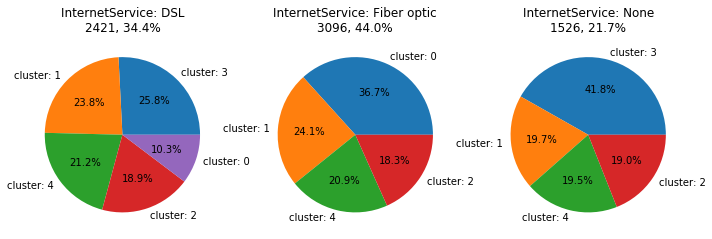

In [2060]:
plot_target_by_feature(df_full,'InternetService','cluster')

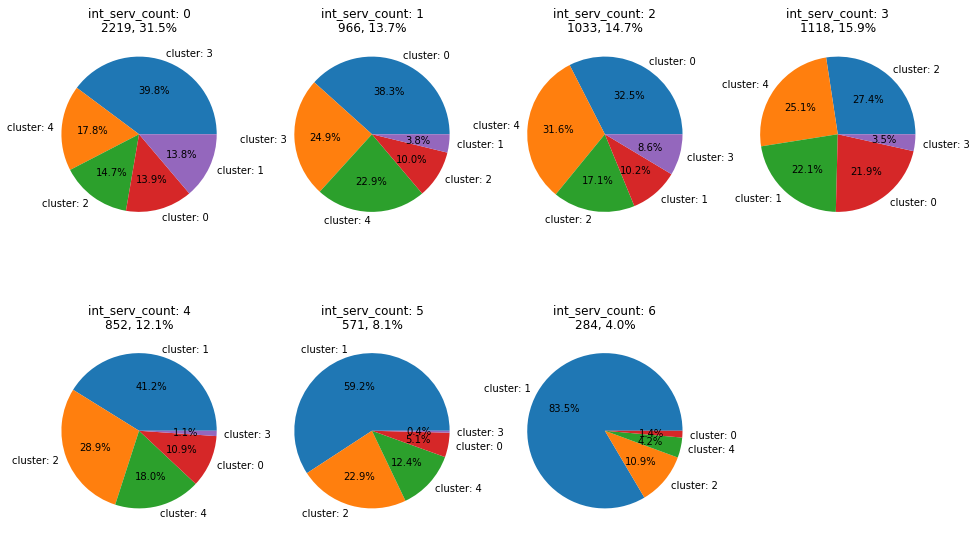

In [2061]:
plot_target_by_feature(df_full,'int_serv_count','cluster')

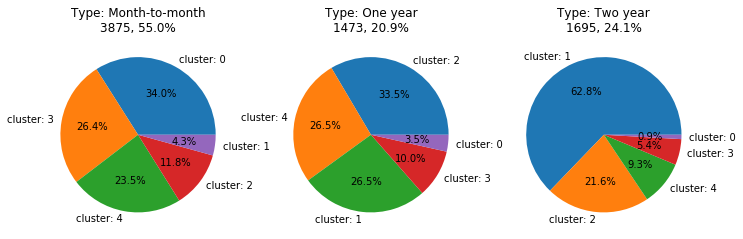

In [2062]:
plot_target_by_feature(df_full, 'Type','cluster')

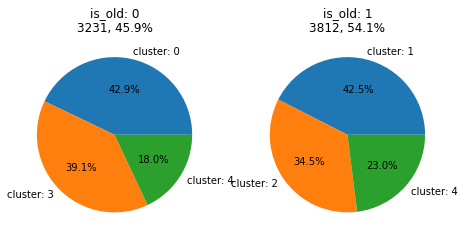

In [2063]:
plot_target_by_feature(df_full, 'is_old','cluster')

Как видно из визулизации есть поля в которх 5 кластеров уверенно разделяются причем достаточно равномерным распределеним по долям.

Теперь точно с фичеинженирингом закончили

## 3.4. Оценим взаимокореляцию

In [2064]:
X_columns = df_OHE.columns[0:-1]

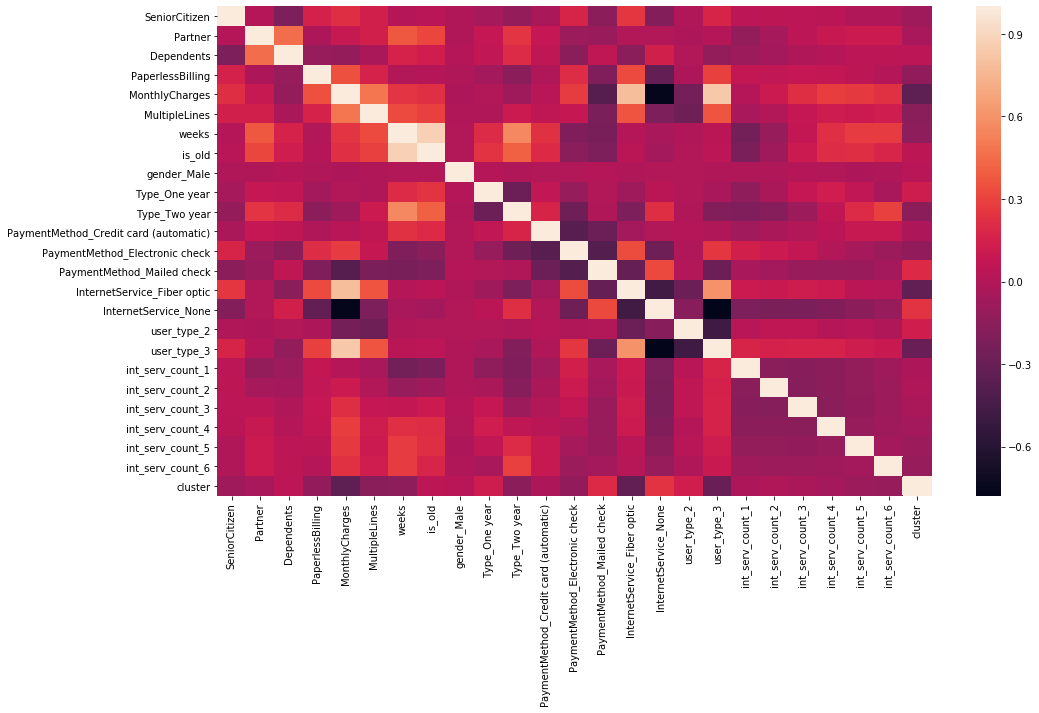

In [2065]:
fig, ax = plt.subplots(figsize= (16,9))

# Тепловая карта
sns.heatmap(df_OHE[X_columns].corr(), ax = ax, annot=False, fmt=".2f");

А сейчас оставим только сочетания с высокой кореляцией >0.7

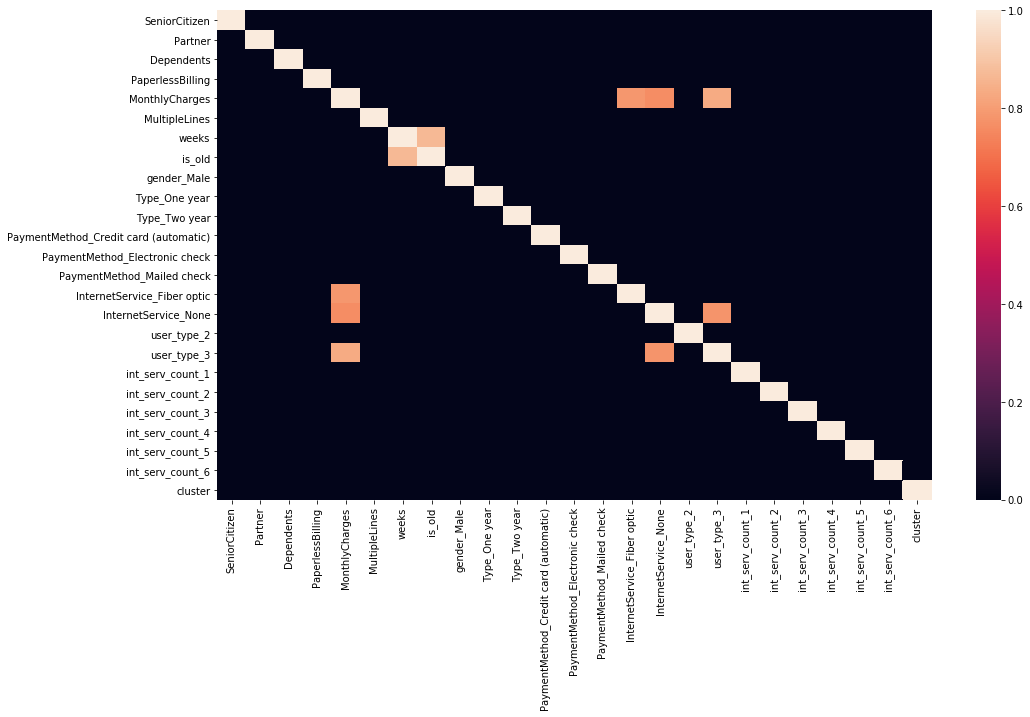

In [2066]:
fig, ax = plt.subplots(figsize= (16,9))
cor = df_OHE[X_columns].corr().abs()
cor2 = cor[cor>0.7]
cor2.fillna(0, inplace = True)

sns.heatmap(cor2, ax = ax, annot=False, fmt=".2f");



На тепловой карте повышенной корреляции видим что есть сочетания с кореляцией выше 0.7. 
Эмперическим путем показано, что устранение оставшихся сочетаний с повышенной кореляцией всетаки ухудшит модель. 
Поэтому имеем условно разумную картину.

## 3.5. Разобъем на тестовые и тренировочные выборки

In [2067]:
y = df_OHE['exited']
X = df_OHE.drop(['exited'], axis = 1)

In [2068]:
X.shape, y.shape

((7043, 25), (7043,))

In [2069]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = .3, random_state = 12345, shuffle=True, stratify=y)

In [2070]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4930, 25), (2113, 25), (4930,), (2113,))

Выполним масштабирование

In [2071]:
# Масштабируем не бинарные числовые колонки. Вновь созданный кластер - тоже
# 'begin_year', 
columns_to_scaler = [ 'weeks', 'MonthlyCharges', 'cluster']

# Приводим в дипазон от 0 - 1
scaler = MinMaxScaler()

X_train.loc[:, columns_to_scaler] = scaler.fit_transform(X_train[columns_to_scaler])
X_test.loc[:, columns_to_scaler] = scaler.transform(X_test[columns_to_scaler])



/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [2072]:
X_test.head()

,SeniorCitizen,Partner,Dependents,PaperlessBilling,MonthlyCharges,MultipleLines,weeks,is_old,gender_Male,Type_One year,...,InternetService_None,user_type_2,user_type_3,int_serv_count_1,int_serv_count_2,int_serv_count_3,int_serv_count_4,int_serv_count_5,int_serv_count_6,cluster
6574,1,0,0,1,0.715212,1,0.124601,0,0,0,...,0,0,1,0,1,0,0,0,0,0.00
2691,0,0,0,1,0.405985,0,0.095847,0,0,1,...,0,0,1,0,1,0,0,0,0,0.00
6329,0,0,0,1,0.857855,0,0.638978,1,0,0,...,0,0,1,0,0,0,0,1,0,0.50
466,1,1,0,0,0.834913,1,0.888179,1,1,0,...,0,0,1,0,0,0,1,0,0,0.25
57,1,1,1,1,0.898254,1,0.916933,1,1,1,...,0,0,1,0,0,0,0,1,0,0.25


## 4. Моделирование LogisticRegression

После серии экспериментов с разными регрессиями, KNeighborsClassifier, SVC, LGBMClassifier ... Вобщем победило быстродействие и простота. Дальнейшая работа будет выполнена на классической LogisticRegression

In [1970]:
# Считаем 2 метрики, оптимизируем по 'roc_auc'

scoring = {'roc_auc': 'roc_auc', 'accuracy':'accuracy'}

In [1971]:
# Стратегия кросвалидации 5 фолдов с перемешиванием баланса классов

cv_ss = StratifiedShuffleSplit(n_splits = 5, test_size =0.25, random_state = state)

In [1972]:
# Логистическая регрессия с балансировкой классов

model_LR = LogisticRegression(class_weight = 'balanced', n_jobs = cores)


#### 4.1 Грубый поиск RandomizedSearchCV

In [1973]:
params = model_LR.get_params()
params

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [1974]:
# Список словарей параметров для рандом поиска

model_LR_grid_param =[
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'sag'], 'C':list(np.linspace(0.01, 200, 30).round())},
    {'penalty': ['l1', 'elasticnet'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],'C':list(np.linspace(0.01, 200, 30).round())}
]


In [1975]:
# Список словарей параметров для рандом поиска

model_LR_grid_param ={
    'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'sag'], 'C':list(np.linspace(2, 200, 15).round())
}
    


In [1976]:
search = RandomizedSearchCV(model_LR, model_LR_grid_param, cv = cv_ss, scoring = scoring, refit ='roc_auc', verbose =1,\
                            n_iter = 100,  random_state = state,  n_jobs = cores) 

In [1977]:
%%time
search.fit(X_train,y_train);

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 45 is smaller than n_iter=100. Running 45 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  2.8min finished


CPU times: user 1min 24s, sys: 1min 23s, total: 2min 48s
Wall time: 2min 48s


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=12345, test_size=0.25,
            train_size=None),
                   error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=-1,
                                                penalty='l2', random_state=None,
                                                solver='warn', t...
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'C': [2.0, 16.0, 30.0, 44.0, 59.0, 73.0,
                                              87.0, 101.0, 115.0, 129.0, 143.0

In [1978]:
search.best_score_

0.850829333495352

In [1979]:
search.best_params_

{'solver': 'newton-cg', 'penalty': 'l2', 'C': 129.0}

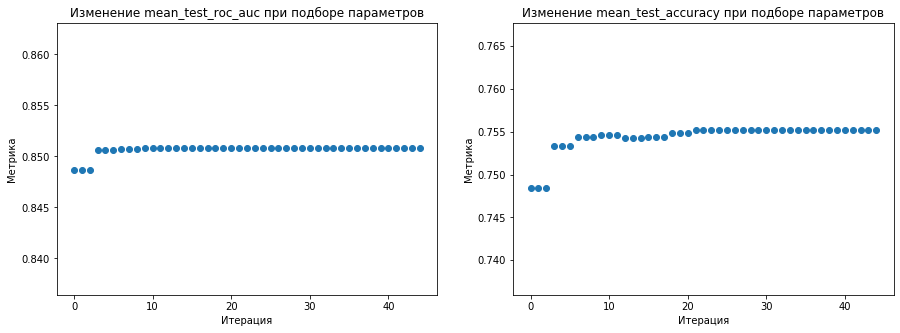

In [1980]:
plot_result(search.cv_results_)

#### 4.2 Более точный поиск GridSearchCV в окрестностях параметров от RandomizedSearchCV

In [1982]:
model_LR_grid_param ={
    'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C':list(np.linspace(120, 200, 21).round())
}


In [1983]:
search = GridSearchCV(model_LR, model_LR_grid_param, cv = cv_ss,  scoring = scoring, refit ='roc_auc', verbose =1, n_jobs=-1)

In [1984]:
%%time
search.fit(X_train,y_train);

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 315 out of 315 | elapsed:  4.2min finished


CPU times: user 2min 6s, sys: 2min 9s, total: 4min 15s
Wall time: 4min 16s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=12345, test_size=0.25,
            train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=-1, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0...
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [120.0, 124.0, 128.0, 132.0, 136.0, 140.0, 144.0,
                               148.0, 152.0, 156.0, 160.0, 164.0, 168.0, 172.0,
                               176.0, 180.0, 184.0, 188.0, 192.0, 196.0,
         

In [1985]:
best_model = search.best_estimator_

In [1986]:
search.best_score_

0.8508300085734924

In [1987]:
search.best_params_

{'C': 128.0, 'penalty': 'l2', 'solver': 'lbfgs'}

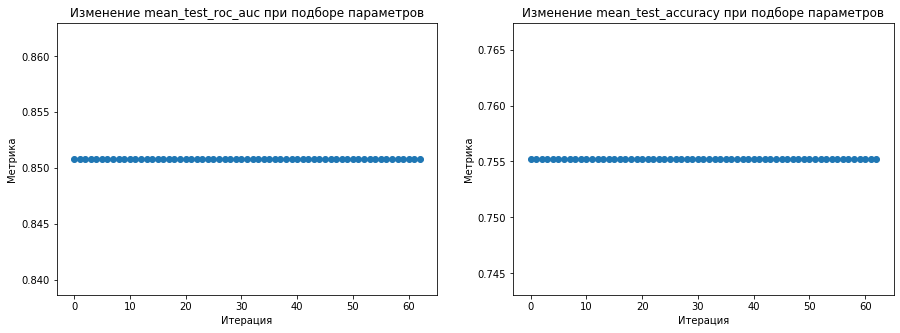

In [1988]:
plot_result(search.cv_results_)

#### 4.3 Итоговые метрики

Тренировочные данные

In [1989]:
prediction = best_model.predict_proba(X_train)[:, 1]

In [1990]:
accuracy_train = accuracy_score(y_train, best_model.predict(X_train))
print('Метрика accuracy на тренировочных данных %.3f'%accuracy_train)
roc_auc_train = roc_auc_score(y_train, prediction)
print('Метрика roc_auc на тренировочных данных %.3f'%roc_auc_train)


Метрика accuracy на тренировочных данных 0.759
Метрика roc_auc на тренировочных данных 0.853


In [1991]:
prediction = best_model.predict_proba(X_test)[:, 1]

In [1992]:

accuracy_test = accuracy_score(y_test, best_model.predict(X_test))
print('Метрика accuracy на тестовых данных %.3f'%accuracy_test)
roc_auc_test = roc_auc_score(y_test, prediction)
print('Метрика roc_auc на тестовых данных %.3f'%roc_auc_test)


Метрика accuracy на тестовых данных 0.746
Метрика roc_auc на тестовых данных 0.838


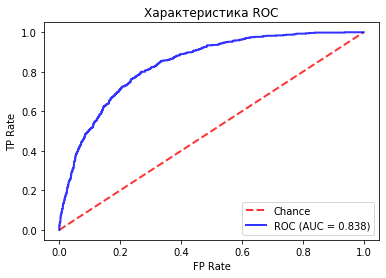

In [1993]:
plot_roc_curve_test(best_model, X_test, y_test)

#### 4.4 Важность фич

In [1994]:
coef = best_model.coef_[0]
df_imp = pd.DataFrame(coef, X_columns, columns =['coef']).sort_values(by = 'coef', ascending =False)
df_imp

,coef
MonthlyCharges,8.938911
is_old,0.916225
user_type_2,0.812033
PaymentMethod_Electronic check,0.360859
PaperlessBilling,0.268525
SeniorCitizen,0.222751
InternetService_None,0.092505
PaymentMethod_Credit card (automatic),0.049020
gender_Male,-0.021409
Partner,-0.025139


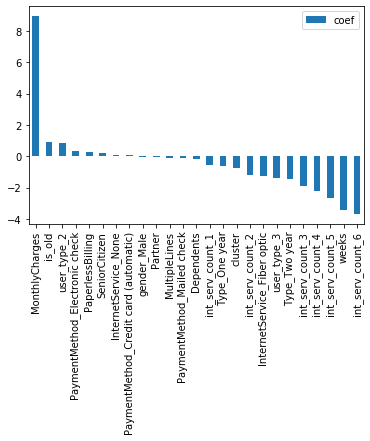

In [1995]:
df_imp.plot.bar();

Важность полученных фич покзала весьма закономерную картину:

Позитивны для оттока:
- По сути только малость ежемесячного платежа
    
Негативны для оттока:
- Число месяцев пользования
- Количество интернет сервисов
- Год заключения


## 5. Моделирование CatBoostClassifier

Возьмем предподготовленные данные без кодирования.

In [2073]:
df_full.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,exited,InternetService,int_serv_count,MultipleLines,user_type,weeks,is_old,cluster
0,Female,0,1,0,Month-to-month,1,Electronic check,29.85,0,DSL,1,0,2,4,0,3
1,Male,0,0,0,One year,0,Mailed check,56.95,0,DSL,2,0,3,148,1,4
2,Male,0,0,0,Month-to-month,1,Mailed check,53.85,1,DSL,2,0,3,8,0,3
3,Male,0,0,0,One year,0,Bank transfer (automatic),42.30,0,DSL,3,0,2,195,1,2
4,Female,0,0,0,Month-to-month,1,Electronic check,70.70,1,Fiber optic,0,0,3,8,0,0


In [2074]:
df_full['weeks']=df_full['weeks'].astype('int')
df_full['cluster']=df_full['cluster'].astype('int')


In [2075]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 16 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null int64
Dependents          7043 non-null int64
Type                7043 non-null object
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
exited              7043 non-null int64
InternetService     7043 non-null object
int_serv_count      7043 non-null int64
MultipleLines       7043 non-null int64
user_type           7043 non-null int64
weeks               7043 non-null int64
is_old              7043 non-null int64
cluster             7043 non-null int64
dtypes: float64(1), int64(11), object(4)
memory usage: 935.4+ KB


In [2076]:
y = df_full['exited']
X = df_full.drop(['exited'], axis = 1)
#X = X.drop(['MonthlyCharges', 'PaperlessBilling', 'Dependents', 'gender', 'SeniorCitizen', 'MultipleLines', 'Partner' ], axis =1 )

#### 5.1 Выделим категориальные колонки и обучим модель из коробки без тюнинга

In [2077]:
categorial_columns = list(set(X.columns) - set([ 'MonthlyCharges']))
#categorial_columns = list(set(X.columns) - set(['MonthlyCharges', 'PaperlessBilling', 'Dependents', 'gender', 'SeniorCitizen', 'MultipleLines', 'Partner' ]))

categorial_columns

['MultipleLines',
 'SeniorCitizen',
 'weeks',
 'int_serv_count',
 'gender',
 'PaperlessBilling',
 'user_type',
 'Partner',
 'Dependents',
 'is_old',
 'cluster',
 'Type',
 'PaymentMethod',
 'InternetService']

In [2078]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = state, shuffle = True)

In [2079]:
cat = CatBoostClassifier(
    cat_features = categorial_columns, 
    n_estimators = 1500, 
    random_state = state,
)

In [2080]:
cat.fit(X_train,y_train,verbose=False , plot = True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### 5.2 Итоговые метрики

Тренировочные данные

In [2089]:
prediction = cat.predict_proba(X_train)[:, 1]

In [2090]:
accuracy_train = accuracy_score(y_train, cat.predict(X_train))
print('Метрика accuracy на тренировочных данных %.4f'%accuracy_train)
roc_auc_train = roc_auc_score(y_train, prediction)
print('Метрика roc_auc на тренировочных данных %.4f'%roc_auc_train)


Метрика accuracy на тренировочных данных 0.8468
Метрика roc_auc на тренировочных данных 0.9111


In [2091]:
prediction = cat.predict_proba(X_test)[:, 1]

In [2092]:

accuracy_test = accuracy_score(y_test, cat.predict(X_test))
print('Метрика accuracy на тестовых данных %.4f'%accuracy_test)
roc_auc_test = roc_auc_score(y_test, prediction)
print('Метрика roc_auc на тестовых данных %.4f'%roc_auc_test)


Метрика accuracy на тестовых данных 0.8115
Метрика roc_auc на тестовых данных 0.8702


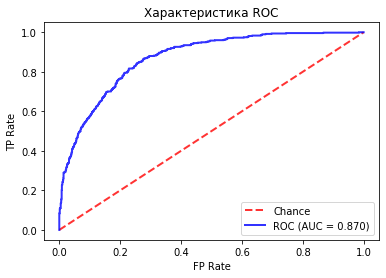

In [2094]:
plot_roc_curve_test(cat, X_test, y_test)

Вот так вот, при нормально подготовленных фичах КатБуст из коробки сделал затюненную регрессию.

#### 5.3 Важность фич

In [2086]:
coef = cat.feature_importances_
df_imp = pd.DataFrame(coef, X.columns, columns =['coef']).sort_values(by = 'coef', ascending =False)
df_imp

,coef
weeks,25.035111
Type,12.189850
MonthlyCharges,11.542328
InternetService,10.624199
cluster,10.014594
PaymentMethod,7.747415
int_serv_count,6.979336
user_type,5.073741
PaperlessBilling,2.491926
is_old,2.084425


С важностью фич тоже все закономерно: Длительность использования, год, количество сервисов.

## 6. Выводы

С учетом того что нужно будет писать отчет по проекту сейчас особо ничего не расписываю.
В целом задача решена, выполнен, как мне показалось условно разумный фиче инженириг, основная работа выполнена на логистической регрессии ну и в заключении оценен результат КатБуста из коробки.

Полученные метрики:

Для логистической регрессии получены результаты:
- Метрика accuracy на тестовых данных 0.802
- Метрика roc_auc на тестовых данных 0.895

Для КатБуста получены результаты:
- Метрика accuracy на тестовых данных 0.863
- Метрика roc_auc на тестовых данных 0.924

## 7. Отчет по проекту

#### План проекта

Шаг 1.  Объединение данных в одну таблицу. Персоны и контракты количество совпадает, пользователи интернет и телефонной связи количество строк меньше, пропуски скорее всего заполним None и это значение будет как новая категория. Далее пользователей только интернет, только телефонии и того и другого тоже категоризирую, возможно буду делать разные модели, либо это будт просто новый признак.

Шаг 2. Новые фичи. Пока видится только срок пользования например в месяцах. Возможно еще год заключения договора.

Шаг 3. Кодование категориальных признаков. Пока по ощущениям буду использова OHE кодирование, количество полей не очень большое и количество значений тоже. Для регрессионной модели подойдет, для деревянных моделей возможно применю боле хитрое кодирование типа закодирую числовой вероятностью этой категории по целевому признаку.

Шаг 4. Дисбаланс классов. Скорее всего придется слегка докинуть целевого класса например методом UpSampling. Возможно балансировку сделаю средтвами модели балансировкой весов. 

Шаг 5. Выполню нормализацию. Разобью  на тестовую и тренировочные выборки. Т.к. это не временной ряд, то с перемешиванием и соблюдением баланса классов.

Шаг 6. Выбор модели. Пока по ощущениям буду использовать Регрессию c регуляризацией и каойто бустинг над деревьями типа LGBM и CatBoost. Дальше что лучше подойдет.

Шаг 7. Метрики. ROC_AUC, accuracy

Шаг 8. Тюннинг моделей. сначала RandomizedSearchCV затем возле лучших значений более точный поиск GridSearchCV

#### В отчёте ответьте на вопросы:

- Какие пункты плана были выполнены, а какие — нет (поясните почему)?
- Какие трудности возникли и как вы их преодолели?
- Какие ключевые шаги в решении задачи выделили?
- Какая ваша итоговая модель и какое у неё качество?

#### Отчет по проекту

1. Что касается пунктов плана. В целом нельзя сказать, что я буквально придерживался изначального плана, однако по сути все шаги и были выполнены, особо ничего не пропущено как и не добавлено. Изначальный план окзался вполне рабочим.

2. Абсолютно верно был исключен вариант временного рядя, даты пригодились только для определения срока пользования. Исключился вариант истории событий по одному пользователю, в данных записи соответствовали уникальным пользователям. Ну и изначально понятна была логика объединения данных и заполнения пропусков.

3. По ходу дела формировались дополнительные фичи, срок пользования, год заключения (по нему с ревьювером развернулась основная дискуссия), количество сервисов, тип пользователя (телефон, интернет, то и другое) 

4. Кроме того, т.к. изначально планировалось OHE кодирование а значит большое число колонок, было ощущение что размерность придется снижать, поэтому была проверена идея предварительной кластеризации пользователей. Ощущение было что этот критерий будет в топе, но оказалось не так, но пару пунктов фича в метрики всетаки добавила. В целом фиче инжиниринг этого проекта доставил удовольствие.

5. Далее были прикинуты простые модели на основе регрессии для оценки что можно ожидать без особого тюнинга, как разложатся фичи, и что можно удалять, ну и вообще нужно ли вообще будет что то делать после регрессии. 

6. Следующим этапом приступил к умеренному тюнингу регрессии, довел метрику до 0.89 что было вполне достаточно для всего, и приступил к оценкам что могут другие модели. Надежда была на LGBMC и прочие подходящие алгоритмы. Без особого тюнинга получить близких метрик не получилось поэтому идею подбором модели почти закончил. 

7. CatBoot эта модель была оставлена на закуску, т.к. на почти не обработанных данных без особого тюнинга может многое. Сообственно что и получилось в моем случает. Метрики которые получились на катбусте были лучше затюненной регрессии. Удалось получить roc_auc 0.92

8. Трудности. 
- Если честно особых трудностей не заметил, вполне понятная задача, вполне понятно как решать, хотя конечно рука еще не набита. - Возможно некоторая трудность которую обозначил ревьювер, что некоторые выводы по данным нужно было делать с использованием оценки гипотез. Учту в дальнейшей работе.
- Ну и объективно не достаточное знание библиотек типа CatBoost. Количество параметров просто безумное, понятно что многое чего там можно сильно улучшить

9. Далее был шаг улучшений по замечаниям ревьювера. Основной момент что изначально в моей модели использовался год начала контракта, и логику его использования я описал в ответах ревьюверу повторяться не буду. Но замечания более опытного товарища надо учитывать, поэтому год был убрал, данные пришлось чуть подточить как и поднастроить модели.

10. Итого, итоговая модель CatBoost итоговые метрики
- Метрика accuracy на тестовых данных 0.8115
- Метрика roc_auc на тестовых данных 0.8702    
приэтом абсолютно понятно, что если в данные протянуть информацию из дат, типа количество дней использования, то метрика roc_auc взлетает до 0.94 и это еще без тюнинга CatBoost 

11. Еще из интересного поигрался всетаки с уменьшением размерности данных, прошелся алгоритмом PCA() уменьшая остаточную дисперсию, и получил интереснейшую картину

<a href="https://imgbb.com/"><img src="https://i.ibb.co/mcjyM2D/70dd6b9a-94f8-4626-b80f-a47d377cb8d9.jpg" alt="70dd6b9a-94f8-4626-b80f-a47d377cb8d9" border="0"></a>


при исходных 25 фичах после OHE метрика от логистической регрессии 0.89, снижая размерность даже до 2 компонент метрика остается на очень приличном уровне, почти 0.8

12. В целом работой доволен, полученным результатом то же.

13. Николаю респект за коменты. Все по делу.